In [ ]:
#!pip install pdfplumber
#!pip install python-docx
#!pip install sentence_transformers 
#!pip install huggingface_hub
#!pip install streamlit
#!pip install gradio

  Using cached uvicorn-0.35.0-py3-none-any.whl.metadata (6.5 kB)
  Using cached websockets-15.0.1-cp313-cp313-win_amd64.whl.metadata (7.0 kB)
  Using cached shellingham-1.5.4-py2.py3-none-any.whl.metadata (3.5 kB)
  Using cached rich-14.1.0-py3-none-any.whl.metadata (18 kB)
  Using cached markdown_it_py-4.0.0-py3-none-any.whl.metadata (7.3 kB)
  Using cached mdurl-0.1.2-py3-none-any.whl.metadata (1.6 kB)
   ---------------------------------------- 0.0/60.2 MB ? eta -:--:--
   ---------------------------------------- 0.0/60.2 MB ? eta -:--:--
   ---------------------------------------- 0.5/60.2 MB 1.9 MB/s eta 0:00:31
    --------------------------------------- 1.3/60.2 MB 2.8 MB/s eta 0:00:22
   - -------------------------------------- 1.6/60.2 MB 2.5 MB/s eta 0:00:24
   - -------------------------------------- 2.1/60.2 MB 2.5 MB/s eta 0:00:24
   - -------------------------------------- 2.6/60.2 MB 2.4 MB/s eta 0:00:24
   -- ------------------------------------- 3.1/60.2 MB 2.4 MB/s et

In [ ]:
# !pip install pdfplumber python-docx weaviate-client sentence-transformers requests

In [ ]:
import os
import pdfplumber
from docx import Document
import weaviate
from weaviate.classes.init import Auth
from weaviate.collections import Collection
from weaviate.classes.config import Property , DataType
from sentence_transformers import SentenceTransformer
import requests
import json

we_url = "your weaviate cluster url/endpoint"
we_api = "your weaviate cluster api"

c:\Users\hamza\anaconda3\envs\RAG\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1. Reading Documents

In [2]:
def check_extention(file):
    _ , extension = os.path.splitext(file)
    return extension

def read_pdf_file(file):
    data = []
    with pdfplumber.open(file) as pdf:
        for i in pdf.pages:
            data.append(i.extract_text())
    return ("\n".join(data))

def read_doc_file(file):
    data=[]
    doc = Document(file)
    for i in doc.paragraphs:
        data.append(i.text)
    return ('\n'.join(data))

def read_text_file(file):
    data = []
    with open(file , 'r') as text:
        data.append(text.read())
    text.close()
    return '\n'.join(data)

def read_doc(file):
    extension = check_extention(file)
    if extension == '.pdf':
        data = read_pdf_file(file)
    elif extension=='.docx':
        data  = read_doc_file(file)
    elif extension=='.txt':
        data = read_text_file(file)

    return data

## Chunking

In [3]:
def chunking(data : str, chunk_size: int = 500 , overlap_size : int= 100):
    data = data.replace('\n' , ' ').split('.')                       #splitting one big para into sentence by '.'  and replacing newline into space.
    final_chunks= []
    current_chunk= []
    current_chunk_size = 0

    for sentence in data:
        sentence = sentence.strip()                                  #.strip remove extra spaces and ne lines
        if not sentence.endswith('.'):
            sentence+=('.')
        sentence_length = len(sentence)

        if current_chunk_size + sentence_length >chunk_size and current_chunk:
            chunk_text = ' '.join(current_chunk)
            final_chunks.append(chunk_text)

            overlap_words = chunk_text[-overlap_size: :+1]
            current_chunk= [overlap_words , sentence]
            current_chunk_size = len(overlap_words) + len(sentence)

        else:
            current_chunk.append(sentence)
            current_chunk_size+=sentence_length
            
    if current_chunk:
        final_chunks.append(' '.join(current_chunk))
        
    return final_chunks

In [15]:

def get_embeddings(chunks):
    model = SentenceTransformer('all-MiniLM-L6-v2')
    embeddings = model.encode(chunks)
    return embeddings

In [10]:

def insert_data_into_weaviate(chunks, embeddings, file, url_name , api_key):
    # Connect to Weaviate Cloud
    client = weaviate.connect_to_weaviate_cloud(
        cluster_url=url_name,
        auth_credentials=Auth.api_key(api_key),
    )
    
    client.collections.create(
    name = "Doc1",
    properties=[
        Property(name = 'source' , data_type = DataType.TEXT),
        Property(name = "chunk"  , data_type = DataType.INT ),
        Property(name = "text"   , data_type = DataType.TEXT),
    ],
    vectorizer_config=None
    )


    docs = client.collections.get("Doc1")

    file_name = os.path.basename(file)
    for i , chunk in enumerate(chunks):
        docs.data.insert(
            properties={
                'source': file_name ,
                'chunk' : i,
                'text' : chunk
            },
            vector = embeddings[i]
    )
    print("Data Inserted Successfully. 👍👍")
    return docs



### After Insertion we can see it visually at weaviate cluster

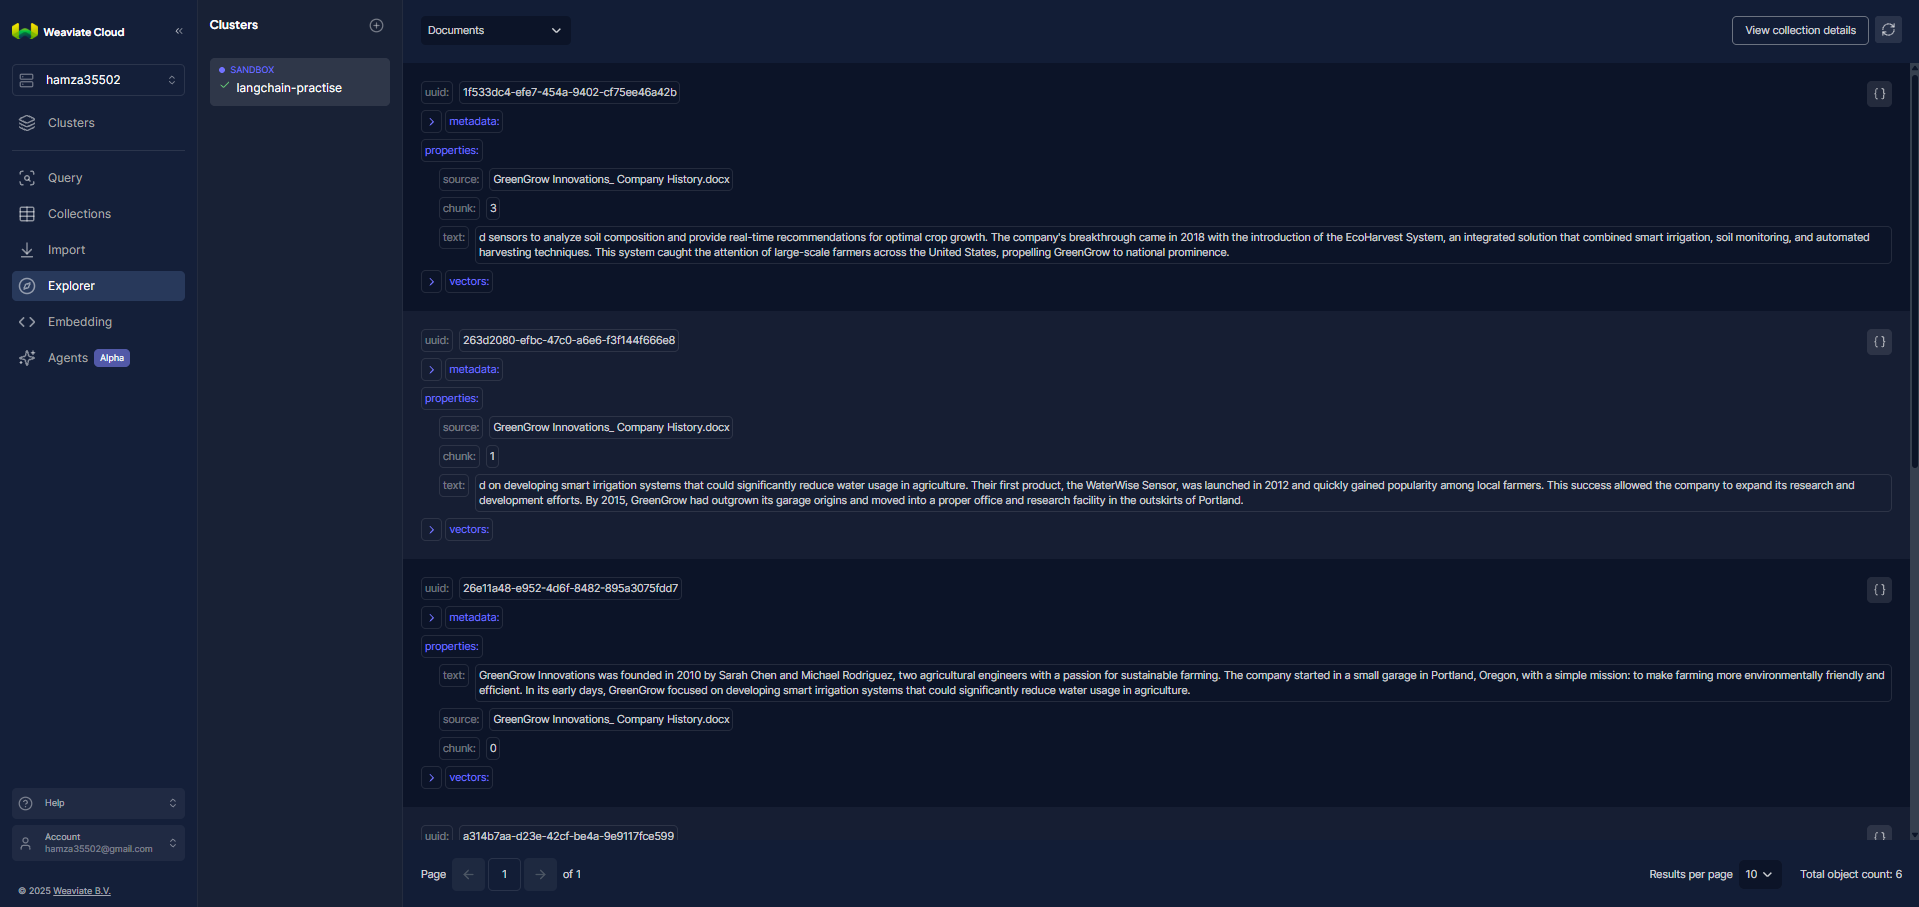

In [6]:
from IPython.display import Image, display

# Display the image
display(Image("content.png",width=1600, height=1600))

### Retrieval Process

In [7]:

def get_nearest_vector(url_name, api_key, docs, query , n : int = 2):
    client = weaviate.connect_to_weaviate_cloud(
        cluster_url=url_name,
        auth_credentials=Auth.api_key(api_key)
        )
    model = SentenceTransformer("all-MiniLM-L6-v2")
    query_vector = model.encode(query)
    result = docs.query.near_vector(
        near_vector=query_vector,
        limit=n
    )
    client.close()
    #return result      for below function return this
    return '\n\n'.join(obj.properties['text'] for obj in result.objects)

def print_nearest_vector(result):
    for obj in result.objects:
        print(obj.uuid)
        for key , value  in obj.properties.items():
            print(f'{key} : {value}')
        print()
        print()
    

In [8]:


def ask_ollama(query , context):
    prompt = f'''You are an AI assistant providing help in question answer keeping the context in mind. Answer consiely by keeping the query in mind.
    
    context: {context}

    query: {query}

    Answer: 
    '''

    response = requests.post(
        'http://localhost:11434/api/generate',
        json = {
            'model' : 'phi3:14b',
            'prompt' : prompt,
            'stream' : False,
        }
    )

    data = response.json()
    return data['response']

In [9]:
file_name = "E:\\New folder\\Simple_RAG_Base_ChatBot\\GreenGrow's EcoHarvest System_ A Revolution in Farming.pdf"
data = read_doc(file_name)
chunks = chunking(data)
embeddings = get_embeddings(chunks)

In [12]:

docs = insert_data_into_weaviate(chunks, embeddings, file_name, we_url, we_api)

Data Inserted Successfully. 👍👍


In [14]:
query_text = 'what are the benifits of eco harvest system?'
context = get_nearest_vector(we_url, we_api, docs, query_text , 5)
answer = ask_ollama(query_text , context)
print(answer)

The EcoHarvest System offers several benefits, including reduced labor costs through its automated harvesting capability and more precise resource usage resulting in minimal crop waste. It employs AI-powered control units to process data from farm sensors for real-time decision making on irrigation, fertilization, and pest control. The smart irrigation module significantly reduces water consumption by up to 40%. Farmers who have implemented the EcoHarvest System report increased crop yields by 20-30% over traditional methods. Additionally, this system contributes positively towards environmental sustainability efforts as it emphasizes resource efficiency and reduced chemical usage.
